In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Load datasets for the agents
x1 = np.load("dataset1.npy") # \in \mathcal{R}^{2}
x2 = np.load("dataset2.npy") # \in \mathcal{R}^{2}
x3 = np.load("dataset3.npy") # \in \mathcal{R}^{2}
x4 = np.load("dataset4.npy") # \in \mathcal{R}^{2}

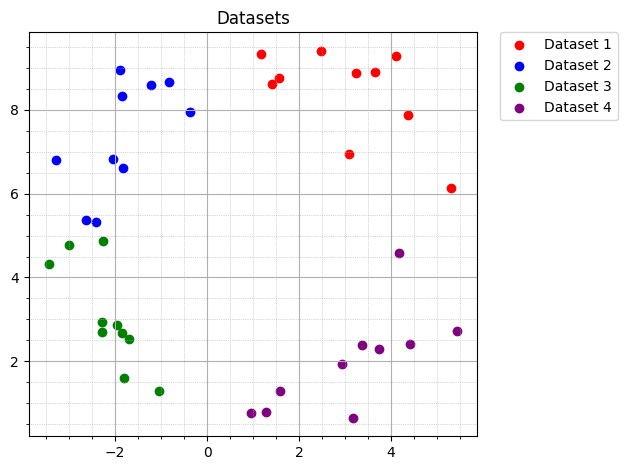

In [28]:
plt.figure(1)
plt.scatter(x1[0], x1[1], color='red', marker='o', label='Dataset 1')
plt.scatter(x2[0], x2[1], color='blue', marker='o', label='Dataset 2')
plt.scatter(x3[0], x3[1], color='green', marker='o', label='Dataset 3')
plt.scatter(x4[0], x4[1], color='purple', marker='o', label='Dataset 4')

plt.grid(True)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.8)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
plt.title("Datasets")

# Move legend outside the plot (to the right)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()

In [29]:
def fit_circle(x):
    """
    Fit a circle to 2D points using least squares.

    Parameters
    ----------
    x : np.ndarray
        2×T array of points [ [x1, x2, ...], [y1, y2, ...] ].

    Returns
    -------
    center : np.ndarray
        (2,) array representing the circle center.
    radius : float
        Estimated radius of the circle.
    circle_points : tuple of np.ndarray
        (circle_x, circle_y) for plotting the circle.
    """

    T = x.shape[1]
    A = np.array([[1, -2*x[0,0], -2*x[1,0]]])
    for k in range(1,T):
        A = np.concatenate((A, [ [1, -2*x[0,k], -2*x[1,k]] ]), axis=0)

    b = np.array( [[ -np.inner(x[:,0], x[:,0]) ]] )
    for k in range(1,T):
        b = np.concatenate((b, [[-np.inner(x[:,k], x[:,k]) ]]), axis=0)

    prob = np.linalg.lstsq(A, b, rcond=None)
    c1 = prob[0].flatten()
    c = c1[1:3]
    y = c1[0]

    R = np.sqrt(np.inner(c, c) - y)

    R = np.sqrt(np.inner(c, c) - y)

    # Precompute circle coordinates for convenience
    theta = np.linspace(0, 2*np.pi, 500)
    circle_x = c[0] + R * np.cos(theta)
    circle_y = c[1] + R * np.sin(theta)

    return c, R, (circle_x, circle_y)

Dataset 1: Center = [2.97016417 7.48830003], Radius = 1.910
Dataset 2: Center = [-1.76271617  7.09397824], Radius = 1.537
Dataset 3: Center = [-1.93484879  3.33716264], Radius = 1.379
Dataset 4: Center = [2.67170265 2.69527835], Radius = 1.971
Dataset 5: Center = [1.20285589 5.12217866], Radius = 4.108


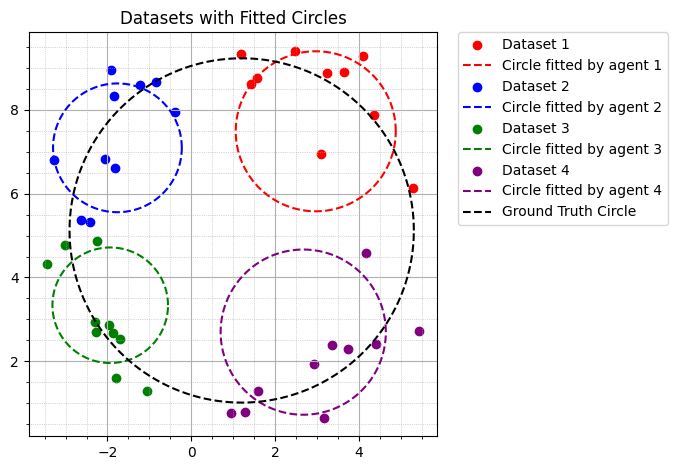

In [30]:
plt.figure(1)
colors = ['red', 'blue', 'green', 'purple', "black"]
datasets = [x1, x2, x3, x4, np.concatenate((x1, x2, x3, x4), axis=1)]

for i, (x, color) in enumerate(zip(datasets, colors)):
    # Fit circle
    center, radius, (circle_x, circle_y) = fit_circle(x)
    print(f"Dataset {i+1}: Center = {center}, Radius = {radius:.3f}")

    # Scatter data points
    if color != "black":  # Avoid duplicate colors for combined dataset
        plt.scatter(x[0], x[1], color=color, marker='o', label=f'Dataset {i+1}')
    # Plot fitted circle
    if color == "black":
        plt.plot(circle_x, circle_y, color=color, linestyle='--', label=f'Ground Truth Circle')
    else:
        plt.plot(circle_x, circle_y, color=color, linestyle='--', label=f'Circle fitted by agent {i+1}')

plt.grid(True)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.8)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
plt.title("Datasets with Fitted Circles")

# Legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

In [31]:
# helper: build local A_p and b_p from 2xT dataset of size (2, 10)
def circle_ls_form(x):
    """
    x: 2 x T numpy array
    returns A: T x 3, b: T x 1 (column)
    A row for point k: [1, -2 x_k, -2 y_k]
    b row: - (x_k^2 + y_k^2)

    corresponds to the equation:
    (x - a)^2 + (y - b)^2 = r^2 Equation of a circle with center (a, b) and radius r, expanding:
    => x^2 + y^2 - 2 a x - 2 b y + (a^2 + b^2 - r^2) = 0
    => 1 * (a^2 + b^2 - r^2) + (-2 x) * a + (-2 y) * b = - (x^2 + y^2)
    => [1, -2x, -2y] [ (a^2 + b^2 - r^2), a, b ]^T = - (x^2 + y^2)
    Vector form: A c = b, where c = [ (a^2 + b^2 - r^2), a, b ]^T
    """
    T = x.shape[1]
    A = np.column_stack((np.ones(T), -2 * x[0, :], -2 * x[1, :]))  # T x 3
    b = -np.sum(x**2, axis=0).reshape(-1, 1)  # T x 1
    return A, b

In [32]:
def ALM(data, c=100.0, eps_ALM=0.01, eps_BCD=0.01, verbose=True):
    """
    data: list of P arrays, each 2 x T (2x10)
    c: ALM penalty parameter
    eps_ALM: stopping tol for ALM (on max constraint violation)
    """

    P = len(data)
    A_list = []
    b_list = []
    for p in range(P):
        A_p, b_p = circle_ls_form(data[p])
        A_list.append(A_p)
        b_list.append(b_p)
    # Initialize
    x0 = np.zeros((3,1)) # global variable
    x_p_list = [np.zeros((3, 1)) for _ in range(P)]  # local variables
    lambda_list = [np.zeros((3, 1)) for _ in range(P)]  # dual variables

    # History and counters
    alm_iter = 0
    alm_history_violation = []
    bcd_iters_per_alm = []

    while True:
        alm_iter += 1
        # Step 1: Minimize L_c over x_p (local variables)
        bcd_iter = 0
        # initialize inner variables for BCD using current outer state
        u0 = x0.copy()
        u_p = [xp.copy() for xp in x_p_list]
        lam_bcd = [lam.copy() for lam in lambda_list]  # lambda are fixed in inner minimization
        while True:
            bcd_iter += 1
            max_change = 0.0
            # Update each x_p
            for p in range(P):
                A_p = A_list[p]
                b_p = b_list[p]
                lam_p = lam_bcd[p]
                # Solve for u_p:
                # solve: \sum_p ||A_p x_p - b_p||^2 + (c/2) ||u_p - u0||^2 + lam_p^T (u_p - u0) 
                # => (c/2) ||u0 - u_p||^2 + lam_p^T (u0 - u_p) = c/2 ||u_p - (u0 - lam_p/c)||^2 - (1/2c) ||lam_p||^2
                # => min_u_p ||A_p u_p - b_p||^2 + (c/2) ||u_p - (u0 - lam_p/c)||^2 - (1/2c) ||lam_p||^2
                # => min_u_p ||A_p u_p - b_p||^2 + (c/2) ||u_p - d_p||^2, where d_p = u0 - lam_p/c
                # => min_u_p ||[A_p; sqrt(c/2) I] u_p - [b_p; sqrt(c/2) d_p]||^2
                d_p = u0 - (lam_p / c)
                A_aug = np.vstack((A_p, np.sqrt(c / 2) * np.eye(3)))
                b_aug = np.vstack((b_p, np.sqrt(c / 2) * d_p))
                
                # Solve least-squares for u_p_new
                u_p_new, *_ = np.linalg.lstsq(A_aug, b_aug, rcond=None)


                ########### Alternative direct solution ############
                # Exact analytical minimizer:
                # (2 A_p^T A_p + c I) x_p = 2 A_p^T b_p + c d_p
                #M = 2 * (A_p.T @ A_p) + c * np.eye(3)
                #rhs = 2 * (A_p.T @ b_p).flatten() + c * d_p.flatten()
                #u_p_new = np.linalg.solve(M, rhs).reshape(3, 1)
                change = (np.linalg.norm(u_p_new - u_p[p])/np.linalg.norm(u_p[p]+0.0000001))  # relative change


                u_p[p] = u_p_new
                if change > max_change:
                    max_change = change
            # Update u0 from the derivative condition:
            # \sum_p [ - lam_p - c (u_p - u0) ] = 0
            # => \sum_p [ c u0 ] = \sum_p [ lam_p + c u_p ]
            # => P c u0 = \sum_p [ lam_p + c u_p ]
            # => u0 = (1/(P c)) \sum_p [ lam_p + c u_p ]
            change0 = np.sum([lam_bcd[p] + c * u_p[p] for p in range(P)], axis=0) / (P * c)
            change0_norm = np.linalg.norm(change0 - u0)
            u0 = change0
            if change0_norm > max_change:
                max_change = change0_norm
            # Check BCD stopping criterion
            if max_change < eps_BCD:
                break
        # End of BCD inner loop
        # Update outer variables
        bcd_iters_per_alm.append(bcd_iter)
        x_p_list = [u_p[p].copy() for p in range(P)]
        x0 = u0.copy()
        # Step 2: Update dual variables
        max_violation = 0.0
        for p in range(P):
            violation = x_p_list[p] - x0
            lambda_list[p] += c * violation
            violation_norm = np.linalg.norm(violation) / np.linalg.norm(x0)  # relative violation
            if violation_norm > max_violation:
                max_violation = violation_norm
        alm_history_violation.append(max_violation)
        print(f"ALM Iteration {alm_iter}: BCD iters = {bcd_iter}")
        # Check ALM stopping criterion
        if max_violation < eps_ALM:
            break
    info = {
        "alm_iters": alm_iter,
        "bcd_iters_per_alm": bcd_iters_per_alm,
        "violation_history": alm_history_violation
    }
                
    return x0, x_p_list, lambda_list, info

                


In [33]:
data = [x1, x2, x3, x4]

# Run ALM+BCD
x0_final, x_p_final, lam_final, info = ALM(data, c=100.0, eps_ALM=0.01, eps_BCD=0.01, verbose=True)

ALM Iteration 1: BCD iters = 170
ALM Iteration 2: BCD iters = 3
ALM Iteration 3: BCD iters = 3
ALM Iteration 4: BCD iters = 2


In [34]:
def x_to_circle(x):
    """
    x: (3,) where x[0] = y, x[1:3] = c (center)
    returns center (2,), radius (float)
    radius = sqrt(||c||^2 - y)
    """
    x = x.flatten()
    y = x[0]
    c_x = x[1]
    c_y = x[2]
    c = np.array([c_x, c_y])
    val = np.dot(c, c) - y
    if val < 0:
        # numerical issues: clamp to zero
        val = max(val, 0.0)
    R = np.sqrt(val)
    return (c_x, c_y), R

Dataset 1: Center = [2.97016417 7.48830003], Radius = 1.910
Dataset 2: Center = [-1.76271617  7.09397824], Radius = 1.537
Dataset 3: Center = [-1.93484879  3.33716264], Radius = 1.379
Dataset 4: Center = [2.67170265 2.69527835], Radius = 1.971
Ground Truth: Center = [1.20285589 5.12217866], Radius = 4.108
RF fitted: Center = [1.2214077505274086, 5.049430575444284], Radius = 4.084


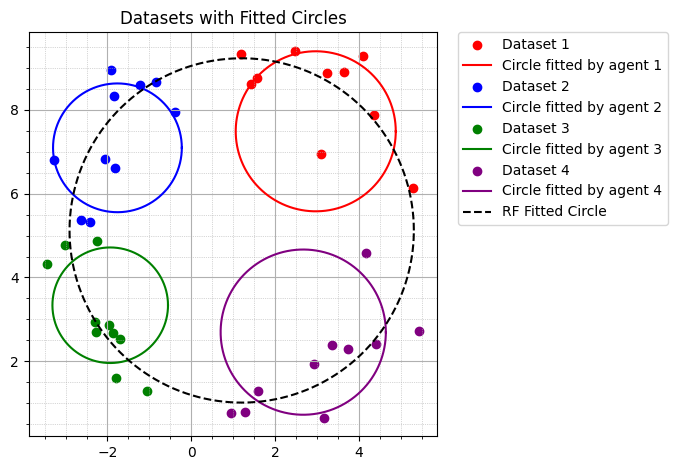

In [35]:
plt.figure(1)
colors = ['red', 'blue', 'green', 'purple', "orange"]
datasets = [x1, x2, x3, x4, np.concatenate((x1, x2, x3, x4), axis=1)]

for i, (x, color) in enumerate(zip(datasets, colors)):
    # Fit circle
    center, radius, (circle_x, circle_y) = fit_circle(x)

    # Scatter data points
    if color != "orange":  # Avoid duplicate colors fobr combined dataset
        print(f"Dataset {i+1}: Center = {center}, Radius = {radius:.3f}")
        plt.scatter(x[0], x[1], color=color, marker='o', label=f'Dataset {i+1}')
    # Plot fitted circle
    if color == "orange":
        print(f"Ground Truth: Center = {center}, Radius = {radius:.3f}")
        #plt.plot(circle_x, circle_y, color=color, linestyle='--', label=f'Dataset Circle')
    else:
        plt.plot(circle_x, circle_y, color=color, linestyle='-', label=f'Circle fitted by agent {i+1}')
(c_x, c_y), R_final = x_to_circle(x0_final)
print(f"RF fitted: Center = {[c_x, c_y]}, Radius = {R_final:.3f}")
plt.plot(circle_x, circle_y, color='black', linestyle='--', label='RF Fitted Circle')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.8)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
plt.title("Datasets with Fitted Circles")

# Legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

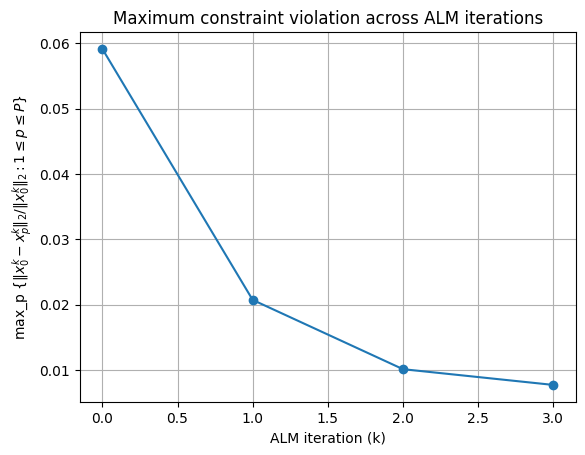


ALM summary:
ALM iterations: 4
BCD iters per ALM iter: [170, 3, 3, 2]
Federated (ALM) center: (1.2214077505274086, 5.049430575444284), radius: 4.083616


In [36]:
# plot violation history
plt.figure()
plt.plot(info['violation_history'], marker='o')
plt.yscale('linear')
plt.xlabel('ALM iteration (k)')
plt.ylabel('max_p {$\| x_0^k - x_p^k\|_2/\|x_0^k\|_2: 1\leq p \leq P$}')
plt.title('Maximum constraint violation across ALM iterations')
plt.grid(True)
plt.show()
# print summary
print("\nALM summary:")
print("ALM iterations:", info['alm_iters'])
print("BCD iters per ALM iter:", info['bcd_iters_per_alm'])
# final center/radius info
c_final, R_final = x_to_circle(x0_final)
print(f"Federated (ALM) center: {c_final}, radius: {R_final:.6f}")

In [37]:
x0_final

array([[10.31266624],
       [ 1.22140775],
       [ 5.04943058]])